#  Simple adaptive flight [dynamic programming with approximate state]

---
### Overview

In the previous experiment we used dynamic programming (policy evaluation, policy iteration and value iteration) to find the optimal flight path through a specific map. In fact the map we used had no obstacles, but we could have introduced them easily enough.

One limitation with that approach is that we cannot adapt to new environments - we learn a single map and that is it. We will now attempt to modify the **agent-state representation** in such a way that we can act on maps we have not seen before. We will also introduce obstacles to increase the problem difficulty. To ensure that we expose the agent to all possible state configurations, it will be trained on a number of randomly generated maps.

The main challange here is to create a state representation which enables good generalisation from past observations; like for a usual NN, generalisation means making decisions based on well designed abstract feature extraction, so you can make the same/different decisions when you identify the same _features_ again in future, not necessarily the same environment. Here we will try to do this by design to help understand the problem, but in general this should be done using the usual DL techniques with a variety of discrete and continuous input features.

A key lesson is that using an approximation, as we are here, means that **dynamic programming is not guaranteed to converge**. To increase the chance of finding a good solution, we must ensure that all information necessary for the decision-making process is contained within the state. If this happens then DP seems to behave well. However, the agent cannot converge on good behaviour when we are missing important information. In our case we define an agent-state which contains all necessary information _if the plane is constrained to always move to the right_. Otherwise, the agent does not know that moving to the left may increase the distance to the objective, and so cannot learn to prioritise righ over left on this basis. We find that our flight trajectories converge nicely in the first case, and not in the second.

A second lesson is that we have to set up our environment, rewards and training data to expose the agent to the selection pressures it needs to learn. These learning pressures should be balanced, stable and not-too-sparse. Furthermore the agent should be exposed to all situations in which it needs to get experience in, which may require providing **dedicated training situations** for situations which may be rare in-the-wild.

For example, we can make the second case work by (i) including distance-to-goal in the state (very inefficient and doesn't generalise to longer maps), or (ii) by changing the **reward signal** so that it encourages movements which take us closer to the goal (discards information about long-term consequences so violates the RL paradigm and requires heavy fine-tuning of reward signal to avoid the immediate reward being outweighed by other penalties - this is essentially equivalent to only allowing actions to the right, but using a fudge). Neither of these solutions are very good for the reasons stated. A better method would be to include the relevant information (unbinned distance-to-goal) in the state, so the agent understands the long-term cost of moving left. To avoid blowing up the size of the state, this must be a continuous variable, so we must discard tabular methods and start using value function approximation (e.g. actor-critic methods).


---
### Details

Description of MDP:
- We consider two different MDPs. The first allows only the three actions which propagate to the right, $a \in \{UR, R, DR\}$. The second also allows movement to the left $a \in \{UR, R, DR, DL, L, UL\}$.
- A map is defined by a grid of values with heights $h \in \{0,1,2,3\}$ and distances $d \in \mathbb{Z}\left([0,x_\mathrm{max}]\right)$  where $x_\mathrm{max}$ is an arbitrary and variable maximum distance. 
- At each $d$ the ground height is set as $g_d \in \{0,1,2\}$. The plane may only touch the ground if it is either the starting or end runway. The flight starts on the runway at position $(d,h)=(0,0)$ and terminates when $d=x_\mathrm{max}$. The end runway is at $(x_\mathrm{max},g_{x_\mathrm{max}})$.
- At each $d$ there may or may not be a cloud at altitude $h=3$.
- Use discount factor of 1 since no infinite horizon problem.
- $p(s'|s,a)$ and $p(r|s',s,a)$ are deterministic and defined as follows:
    - Baseline reward $r = 4 - h_s$ where $h_s$ is the height of the initial state. This encourages the flight to gain altitude to reduce future rewards, and ensures the minimal reward is $+1$ so the flight is incentivised to finish as soon as possible.
    - Actions attempt to move spaces as described.
        - If the new square is out-of-bounds then $r \rightarrow r + r_\mathrm{boundary}$ and we are returned to our previous square, so $s'=s$. Otherwise we pick up a penalty $r \rightarrow r + r_\mathrm{climb}$ if our height has increased and $r \rightarrow r + r_\mathrm{descent}$ if it has decreased. By default $r_\mathrm{boundary}=5$, $r_\mathrm{climb}=3$ and $r_\mathrm{descent}=0$. 
        - If the new square is at the same height as the ground and $d \notin \{0, d_{x_\mathrm{max}}\}$ then we crash with $r \rightarrow r + r_\mathrm{crash}$ and are returned to our previous square, $s'=s$. By default $r_\mathrm{crash}=50$. The game does not terminate so we avoid purposefully crashing when $r_\mathrm{crash}$ is configured too low such that crashing would provide a lower reward than continuing to navigate a long map. This also reduces our sensitivity to the scale of $r_\mathrm{crash}$ (it should probably not be too large or small to avoid instability in learning).
        - If the new square is in a cloud then we pick up a penalty of $r \rightarrow r + r_\mathrm{cloud}$. By default $r_\mathrm{cloud}=2.5$. This means that we should continue to fly through a cloud if it only extends for one space, since the penalty for descending, flying low and climbing again ($r_\mathrm{decend}+1+r_\mathrm{climb}=3$) is higher than $r_\mathrm{cloud}$. However we should avoid it and fly lower if there are at least two and the ground height allows lower flying, since $r_\mathrm{descend}+2+r_\mathrm{climb}=4 ~<~ 2r_\mathrm{cloud}=5$. This is a slightly more advanced level of reasoning to learn.
        - If $s'$ is the end runway then terminate with $r=0$. If $d_{s'}=x_\mathrm{max}$ then we terminate with $r = r_\mathrm{missed}$. By default $r_\mathrm{missed}=50$.
   
Description of the state:
- A state is defined by the following 6 observables:
    - current height: $\{0, 1, 2, 3\}$ (size 4)
    - height of ground in the next space:  $\{0, 1, 2\}$ (size 3)
    - is there a cloud in the next space?: $\{0, 1\}$ (size 2)
    - height of ground in the space after:  $\{0, 1, 2\}$ (size 3)
    - is there a cloud in the space after?: $\{0, 1\}$ (size 2)
    - distance to end runway: $\{1, 2, 3, \geq4\}$ (size 4)
- The size of the state space is $4\times3\times2\times3\times2\times4=576$.
- This state is designed to contain all the information required to figure out whether it is beneficial to climb or descend. Note that
    - We don't need to know the current gound height.
    - We need to know the height of the next space to avoid crashing.
    - We need to know the height of the space after to know whether we can avoid clouds, and to see whether we need to start descending if the final runway is both low and near.
    - We need to know whether there are clouds in the next two spaces to inform our decision of whether to fly through or avoid them.
    - The game terminates when $d=x_\mathrm{max}$, so these states are never visited and distance-to-runway cannot be $0$
- States with e.g. a current-$h$ of $0$ and a next-$g$ of $2$ are not possible as this would mean that we are currently underground. These states will never be visited, and we will purposefully avoid evaluating them to avoid unexpected behaviour.
- Since the distance-to-runway can be so large, and all distances $\geq4$ behave roughly the same, we gather them into the same bin to reduce the size of the state space. However this breaks the Markov property of our MDP, since the probability of transitioning into the $3$ bin depends on both the map configuration _and_ the current policy. This seemed like a reasonable approach, but we find that it causes major problems when the MDP is not forced to always choose actions to the right. As detailed below, this is because we have thrown away the information about how transitioning left or right affects our distance from the end - just using the state information we do not know which way to go to reach the runway!

Advantages of this approach:
- Can immediately apply result to new maps with arbitrary length and randomly generated landscape.
- Solutions generalise to maps much longer than those trained on, and for which the full-state-representation would be prohibitively large.
- Advantage of tabular approaches: we satisfy one criterion for guaranteed convergence (unfortunately function approximation still breaks this here). Furthermore we do not observe instabilities by pathologically transferring information between states.

Disadvantages of this approach:
- Approximation used, which means that dynamic programming is not guaranteed to converge.
- Whilst you can always frame something as a MDP, you have to absorb information into state, which easily makes the state space too large to solve with DP since size(S) ~ exp{dim[S]}
- Way we configure state defines whole learning dynamics. If we do it badly, we do not contain the information needed to make decisions. This makes value iteration diverge. Value iteration seems to be well behaved as long as we _always_ have the information required to inform our decision (N.B. this could include the decision to explore to gain more information).
- Disadvantage of tabular approaches: cannot share information between similar states using inductive bias. E.g. the presence of cloud in second space is irrelevant if this space is a runway so we would learn more efficiently by merging the is-cloud bins in these cases. By contrast, the tabular approach means that states are modelled completely independently, which is very data inefficient.
- **Important lesson**: if we don't enforce going right, then there are many occasions when both left and right actions will lead to the same next agent state. In these cases, there is no selection pressure towards going right rather than left. Sometimes it may learn other auxilliaries like "go  right when there is a hill" since the hill allows an orientation to be defined and preferred, but this is not a catch-all. This highlights the problems which can occur when all needed information is not well defined within the agent state (in this case the progress-towards-objective). In our case this leads to infinite orbits.

Other notes:
- Map generation: the ground height cannot change by more than 1 for consecutive squares, meaning that the plane can always climb over a hill.
- Map generation: the probability of there being a cloud is large if there was a cloud previously and small otherwise
- As always, a defining feature of the problem the reward paradigm, which we must set up in a way which allows for stable and efficient learning even when situational rewards are sparse and may occur arbitrarily far into future.
- Another defining feature is how we expose the agent to different situations and rewards. We train by generating new maps at every iteration, to make sure the agent is exposed to all possible map states and properly accounts for the different frequencies of possible transitions.
- For a continuous state representation we would always know how far we are from the runway, but would it learn how to extrapolate to longer distance than it has previously observed? I.e. if we trained on maps of length 20, then introduced the agent to a map of length 100, would it know that it all large-distances should be treated the same and move to the right?
- Whilst the probability of the environment transitioning under a given action is deterministic, the agent transitions are stochastic, since the same s,a may lead to different s' in different positions on the map.
- As soon as we start using an approximate state representation, we break the MDP property, since the same agent-state may represent different configurations of the game which may occur with different frequencies and also imply very different optimal policies. Furthermore the frequencies may depend on policy which means that prob(next state, reward) changes as the policy evolves. A good state-representation is one for which the expected p(s'|s,a) and p(r|s,a) are independent of the agent state
- To create an efficient compressed state representation it would be important to train in a way which extracts the generalisable features, and be able to localise them if needed
- A full tabular state representation does not suffer from forgetting. However, a NN-based method will try to re-use neurons to help describe the data it sees, which may lead to the forgetting of information for rare states and events, or those it was trained on a long time ago. This is similar to a human but maybe not desirable.
- We can use rogue values in the state-representation when using the tabular method, since we don't have an inductive bias to pathologically transfer step function onto the physical regime, however this would be a problem if using e.g. a NN. In general don't like step functions in NNs as it introduces a high-dim discontinuity into the function being modelled, which NNs can only approximate and possibly not very well depending on how abrupt and regular the transitions are.
- We model action value function avfe instead of value function vfe because vfe is heavily dependent on map and policy.

---

### Define methods

In [1]:
###
###  Required imports
###

import os, sys, time
import numpy as np
from matplotlib import lines as mlines, patches as mpatches, pyplot as plt

In [2]:
###
###  Configure MDP
###
#
# Only two MDP settings to choose:
# >  whether to allow actions which go left
# >  whether to include reward (penalty) for getting closer (farther) from goal
# Also define access functions to toggle these on/off
#

do_allow_actions_left   = False
do_reward_actions_right = False
max_a = 3   # Maximum number of actions, defines size of action value function and policy

def allow_actions_left(do_allow=None) :
    '''
    Returns value of global do_allow_actions_left. 
    If bool provided then also sets global do_allow_actions_left and max_a.
    Inputs:
       do_allow: bool, default=None
                 set global do_allow_actions_left to this value and 
    Returns:
       float: value of do_allow_actions_left
    '''
    global max_a, do_allow_actions_left
    if type(do_allow) is bool :
        do_allow_actions_left = do_allow
        max_a = 6 if do_allow_actions_left else 3
    return do_allow_actions_left

def reward_actions_right(do_reward=None) :
    '''
    Returns value of global do_reward_actions_right. 
    If bool provided then also sets global do_reward_actions_right.
    Inputs:
       do_reward: bool, default=None
                  set global do_reward_actions_right to this value and 
    Returns:
       float: value of do_reward_actions_right
    '''
    global do_reward_actions_right
    if type(do_reward) is bool :
        do_reward_actions_right = do_reward
    return do_reward_actions_right


In [3]:

def get_empty_avfe() :
    '''Return numpy array of zeros with the shape of the action value function'''
    return np.zeros(shape=(4, 3, 2, 3, 2, 4, max_a))

def get_empty_policy() :
    '''Return numpy array of zeros with the shape of the policy'''
    return np.zeros(shape=(4, 3, 2, 3, 2, 4, max_a))

def get_initial_policy() :
    '''Return policy with equal probability for all possible actions'''
    return np.full(shape=(4, 3, 2, 3, 2, 4, max_a), fill_value=1./float(max_a))

def get_height_above_SL(s) :
    '''Return current height above sea level for a given state s'''
    return s[0]

def get_next_space_has_cloud(s) :
    '''Return True if the next space has a cloud for a given state s'''
    return s[1]

def get_next_space_ground_height(s) :
    '''Return ground height in the next space for a given state s'''
    return s[2]

def get_second_space_has_cloud(s) :
    '''Return True if the space after next has a cloud for a given state s'''
    return s[3]

def get_second_space_ground_height(s) :
    '''Return ground height in the space after next for a given state s'''
    return s[4]

def get_distance_to_runway(s) :
    '''Return distance to runway for a given state s (4 means >= 4)'''
    return s[5] + 1

def generate_game_board(length=51) :
    '''
    Create a new game board with the desired length
    Inputs:
       length: int, default = 51
               length of the game board to create
    Returns:
       list of length length, types int : profile of ground heights as function of d
       list of length length, types bool: profile of is-cloud? as function of d
    '''
    ground_heights, is_clouds = [0, 0], [0, 0]
    ground_height , is_cloud  = ground_heights[0], is_clouds[0]
    ground_change = np.random.choice([-1, 0, 1], size=(length-3,), p=[0.4, 0.4, 0.2])
    for x_idx, delta_ground in enumerate(ground_change) :
        ground_height = min(2, max(0, ground_height + delta_ground))
        is_cloud      = np.random.choice([0,1], p=[.3, .7]) if is_cloud else np.random.choice([0,1], p=[.8, .2])
        ground_heights.append(ground_height)
        is_clouds     .append(is_cloud     )
    ground_heights.append(ground_heights[-1])
    is_clouds     .append(is_clouds     [-1])
    return ground_heights, is_clouds

def get_state(game_board, d, h) :
    '''
    Return the state representation for an agent in the current square
    Inputs:
       game_board: (list, list)
                   (profile of grounds heights, profile of is-cloud?) which define the game board
       d         : int
                   horizontal distance from start
       h         : int
                   vertical height
    '''
    ground_heights, is_clouds = game_board
    h                      = min(3, max(0, h))
    max_d                  = len(ground_heights) - 1
    next_space_g           = ground_heights[d+1] if d < max_d else 0
    next_space_has_cloud   = is_clouds     [d+1] if d < max_d else 0
    second_space_g         = ground_heights[d+2] if d < max_d - 1 else 0
    second_space_has_cloud = is_clouds     [d+2] if d < max_d - 1 else 0
    distance_to_runway     = min(4, max_d - d)
    sp = [h, next_space_g, next_space_has_cloud, second_space_g, second_space_has_cloud, distance_to_runway-1]
    return sp
    
def get_next_state_and_reward(game_board, d, h, a, climb_penalty=3., descent_penalty=0., boundary_penalty=5.,
                              missed_approach_penalty=50., crash_penalty=50., cloud_penalty=2.5,
                              goal_progress_penalty=1.) :
    '''
    Perform action in current state, and consequent next state and reward
    Inputs:
       game_board             : (list, list)
                                (profile of grounds heights, profile of is-cloud?) which define the game board
       d                      : int
                                current horizontal distance from start
       h                      : int
                                current vertical height
       a                      : int
                                action to be performed
       climb_penalty          : float, default = 3.
                                reward for climbing
       descent_penalty        : float, default = 0.
                                reward for descending
       boundary_penalty       : float, default = 5.
                                reward for hitting boundaries an minimum d and minimum/maximum h
       missed_approach_penalty: float, default = 50.
                                reward for reaching a terminal state which is not the end runway
       crash_penalty          : float, default = 50.
                                reward for crashing into the ground
       cloud_penalty          : float, default = 2.5
                                reward for passing through a space with a cloud
       goal_progress_penalty  : float, default = 1.
                                reward for moving away from the goal (and -ve reward for moving towards it)
                                reward is only applied if configured using accessor reward_actions_right()
    Returns:
       list of length 6, type ints: indices representing next state representation
       int or float               : emitted reward
    '''
    ground_heights, is_clouds = game_board
    max_d = len(ground_heights) - 1
    # if already terminal state then don't do anything
    if d == max_d :
        raise ValueError(f"d={d} is a terminal state which I am not programmed to deal with")
    # if already crashed then don't do anything
    g = ground_heights[d]
    if d != 0 and h <= g :
        raise ValueError(f"h={h} is below the current ground height g={g} which should not be possible")
    # otherwise try to perform action
    r, new_d, new_h = float(4 - h), d, h
    if a in [0, 1, 2] : new_d += 1
    hit_boundary = False
    if a in [3, 4, 5] : 
        new_d -= 1
        if new_d < 0 :
            hit_boundary = True
    if not hit_boundary :
        if a in [0, 5] : 
            new_h += 1
            if new_h >= 4 :
                hit_boundary = True
            else :
                r += climb_penalty
    if not hit_boundary :
        if a in [2, 3] : 
            new_h -= 1
            if new_h < 0 :
                hit_boundary = True
            else :
                r += descent_penalty
    if hit_boundary :
        r += boundary_penalty
        new_d, new_h = d, h
    # figure out if we've finished
    new_g = ground_heights[new_d]
    if new_d == max_d :
        if new_h != new_g :
            return None, missed_approach_penalty
        return None, 0.
    # figure out if we've crashed
    if new_h <= new_g :
        r += crash_penalty
        new_d, new_h = d, h
    # figure out if we're in a cloud
    new_is_cloud = is_clouds[new_d]
    if new_h == 3 and new_is_cloud :
        r += cloud_penalty
    # reward a movement towards the goal if configured to do so
    if reward_actions_right() :
        r += (d - new_d)*goal_progress_penalty
    # create new state
    sp = get_state(game_board, new_d, new_h)
    return sp, r

def iterate_avfe(game_board, avfe, policy, discount_factor=1.) :
    '''
    Return iterated version of the action value estimates
    Inputs:
       game_board     : (list, list)
                        (profile of grounds heights, profile of is-cloud?) which define the game board
       avfe           : np.ndarray of shape (4,3,2,3,2,4,max_a)
                        current action value esimates
       policy         : np.ndarray of shape (4,3,2,3,2,4,max_a)
                        policy values
       discount_factor: float, default = 1.
                        value of discount factor
    Returns:
       np.ndarray of shape (4,3,2,3,2,4,max_a): iterated action value estimates
    '''
    ground_heights, is_clouds = game_board
    counts, new_avfe = get_empty_avfe(), avfe.copy()
    for x in range(len(ground_heights)-1) :
        for h in range(ground_heights[x], 4) :
            if x != 0 and h == ground_heights[x] : continue
            s = get_state(game_board, x, h)
            for a in range(max_a) :
                sp, r = get_next_state_and_reward(game_board, x, h, a)
                G = r
                if type(sp) != type(None) :
                    vs = avfe  [sp[0],sp[1],sp[2],sp[3],sp[4],sp[5]]
                    ps = policy[sp[0],sp[1],sp[2],sp[3],sp[4],sp[5]]
                    for ap, (p, v) in enumerate(zip(ps, vs)) :
                        G += discount_factor*p*v
                old_counts  = counts  [s[0],s[1],s[2],s[3],s[4],s[5],a]
                old_value   = new_avfe[s[0],s[1],s[2],s[3],s[4],s[5],a]
                new_counts  = old_counts + 1
                new_avfe[s[0],s[1],s[2],s[3],s[4],s[5],a] = (old_value*old_counts + G) / new_counts
                counts  [s[0],s[1],s[2],s[3],s[4],s[5],a] = new_counts
    return new_avfe

def get_greedy_policy(avfe) :
    '''
    Return the greedy policy associated with a given set of action value estimates
    Inputs:
       avfe: np.ndarray of shape (4,3,2,3,2,4,max_a)
             current action value esimates
    Returns:
       np.ndarray of shape (4,3,2,3,2,4,max_a): greedy policy values
    '''
    policy = get_empty_policy()
    for i in range(4) :
        for j in range(3) :
            for k in range(2) : 
                for l in range(3) :
                    for m in range(2) :
                        for n in range(4) :
                            best_a, best_v = [], np.inf
                            vs = avfe[i,j,k,l,m,n]
                            for a, v in enumerate(vs) :
                                if v > best_v : continue
                                if v == best_v :
                                    best_a += [a]
                                    continue
                                best_a = [a]
                                best_v = v
                            for a in best_a :
                                policy[i,j,k,l,m,n,a] = 1. / len(best_a)
    return policy

def perform_policy_iteration(num_itr, num_subtr=1, length=21, verbose=True) :
    '''
    Returns policy obtained by a number of policy iterations
    Inputs:
       num_itr  : int
                  number of times to iterate policy
       num_subtr: int, default = 1
                  number of times to iterate action value estimates for every policy update
       length   : int, default = 21
                  length of new map to generate for each policy update
       verbose  : bool, default = True
                  if True then intermittently print status to sys.stdout
    Returns:
       policy: np.ndarray of shape (4,3,2,3,2,4,max_a)
               greedy policy values
    '''
    #
    #  Initialise variables
    #
    start_time = time.time()
    policy     = get_initial_policy()
    avfe       = get_empty_avfe()
    #
    #  Perform outer loop of policy updates and inner loop of action value updates
    #  For each policy update, generate a new map so agent is eventually exposed to all possible states
    #
    if verbose :
        sys.stdout.write(f"Policy iteration 0% complete")
    for i in range(num_itr) :
        game_board = generate_game_board(length=length)
        for j in range(num_subtr) :
            avfe = iterate_avfe(game_board, avfe, policy)
        policy = get_greedy_policy(avfe)
        if verbose :
            if 100*(i+1) % num_itr == 0 :
                sys.stdout.write(f"\rPolicy iteration {100.*(i+1)/num_itr:.0f}% complete [{time.time()-start_time:.2f}s]")
    return policy


In [4]:

def draw_game_board(game_board) :
    '''
    Inputs:
       game_board: (list, list)
                   (profile of grounds heights, profile of is-cloud?) which define the game board
    Returns:
       fig: plt.Figure object
            figure containing plot
       ax : plt.AxesSubplot object
            axes containing plot
    '''
    ground_heights, is_clouds = game_board
    length = len(ground_heights)
    fig = plt.figure(figsize=(15,4))
    ax  = fig.add_subplot(1, 1, 1)
    ax.tick_params(right=True, top=True, direction="in", labelsize=13)
    for i in range(length) : ax.axvline(i+0.5, c="gray", lw=0.4)
    for j in range(3) : ax.axhline(j+0.5, c="gray", lw=0.4)
    for idx, ground_height in enumerate(ground_heights) :
        if idx == 0 or idx == length - 1 :
            ax.fill_between([idx-0.5, idx+0.5], -0.5             , ground_height-0.5, color="palegreen")
            ax.fill_between([idx-0.5, idx+0.5], ground_height-0.5, ground_height+0.5, color="darkred")
        else :
            ax.fill_between([idx-0.5, idx+0.5], -0.5, ground_height+0.5, color="palegreen")
    for idx, is_cloud in enumerate(is_clouds) :
        if not is_cloud : continue
        ax.fill_between([idx-0.5, idx+0.5], 2.5, 3.5, color="lightgray")
    ax.set_xlim(-0.5, length-0.5)
    ax.set_ylim(-0.5, 3.5)
    ax.set_yticks([0, 1, 2, 3])
    return fig, ax

In [5]:
def generate_directory_for_file_path(fname, print_msg_on_dir_creation=True) :
    """
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                                    if True then print a message whenever a new directory is created
    """
    while "//" in fname :
        fname = fname.replace("//", "/")
    dir_tree = fname.split("/")
    dir_tree = ["/".join(dir_tree[:i]) for i in range(1,len(dir_tree))]
    dir_path = ""
    for dir_path in dir_tree :
        if len(dir_path) == 0 : continue
        if not os.path.exists(dir_path) :
            os.mkdir(dir_path)
            if print_msg_on_dir_creation :
                print(f"Directory {dir_path} created")
            continue
        if os.path.isdir(dir_path) : 
            continue
        raise RuntimeError(f"Cannot create directory {dir_path} because it already exists and is not a directory")
    

In [6]:

def draw_flightpath(game_board, policy, savefile="", show=False, dpi=300) :
    '''
    Create a plot showing the flightpath evaluated over the game board provided, using the policy provided
    '''
    ground_heights, is_clouds = game_board
    fig, ax    = draw_game_board(game_board)
    max_d      = len(game_board[0]) - 1
    max_itr    = max_d + 10
    itr_idx    = 0
    d, h       = 0, 0
    is_crashed = False
    while d < max_d and (not is_crashed) and itr_idx < max_itr :
        s     = get_state(game_board, d, h)
        a     = np.argmax(policy[s[0],s[1],s[2],s[3],s[4],s[5]])
        sp, _ = get_next_state_and_reward(game_board, d, h, a)
        new_d, new_h = d, h
        if a in [0, 1, 2] : new_d += 1
        if a in [3, 4, 5] : new_d -= 1
        if a in [0, 5]    : new_h += 1
        if a in [2, 3]    : new_h -= 1
        new_d = max(0, new_d)
        new_h = max(0, min(3, new_h))
        ax.plot([d, new_d], [h, new_h], "--", lw=2, c="red")
        d, h  = new_d, new_h
        itr_idx += 1
        if new_h == ground_heights[new_d] :
            is_crashed = True
    handles = [mpatches.Patch(facecolor='palegreen'), mpatches.Patch(facecolor='lightgray'), 
               mpatches.Patch(facecolor='darkred'), mlines.Line2D([], [], ls="--", lw=2, c="red")]
    labels  = ["Ground", "Clouds", "Runway", "Flight path"]
    ax.legend(handles, labels, loc=(0, 1.01), fontsize=15, ncol=4, frameon=False)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    if show :
        plt.show(fig)
    return fig, ax


---

### Study example when only allowing actions which move to the right

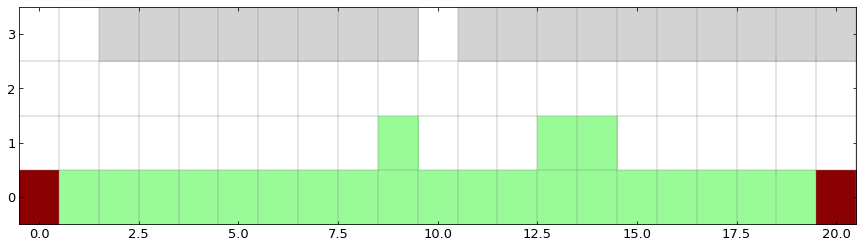

In [7]:
###
###  Draw an example game board
###

game_board = generate_game_board(length=21)
fig, ax    = draw_game_board(game_board)
plt.show(fig)
plt.close(fig)


In [8]:
###
###  Perform policy or value iteration
###
#
#  Configure iterative updates
#

num_itr   = 10000    # Number of times to iterate policy
num_subtr = 1        # Number of times to iterate action values before performing greedy policy update
length    = 21       # Length of maps to generate

policy = perform_policy_iteration(num_itr, num_subtr, length)

Policy iteration 100% complete [13.63s]

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_3actions_itr0.pdf


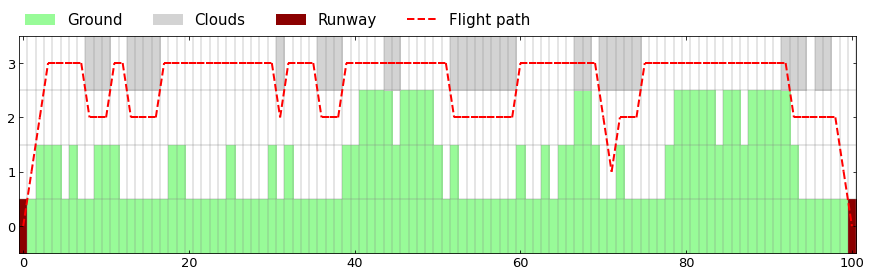

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_3actions_itr1.pdf


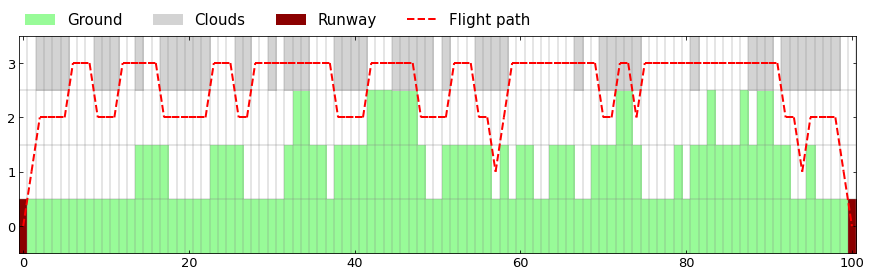

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_3actions_itr2.pdf


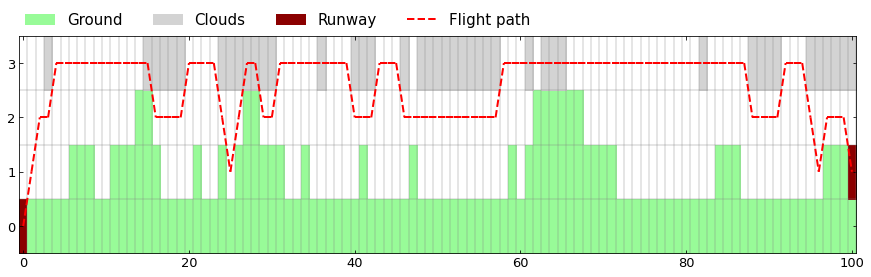

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_3actions_itr3.pdf


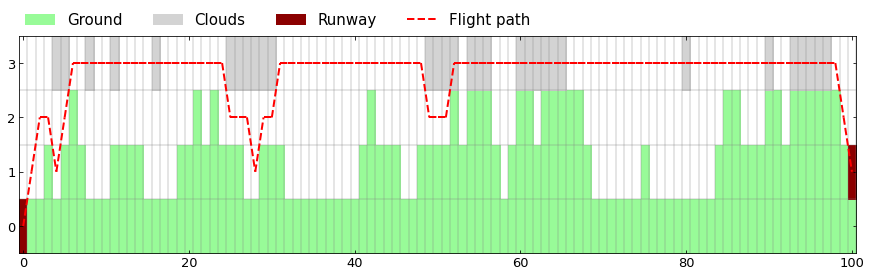

In [9]:
###
###  Plot the flightpaths evaluated for a number of different randomly generated maps
###
#
#  Configure the length and number of flights to show
#

length      = 101
num_flights = 4

#
#  Loop and plot flights requested
#
for flight_idx in range(num_flights) :
    game_board = generate_game_board(length=length)
    fig, ax = draw_flightpath(game_board, policy, 
                              savefile=f"figures/Simple_adaptive_flight_dynamic_programming/Flightpath_3actions_itr{flight_idx}.pdf")
    plt.show(fig)
    plt.close(fig)
    

### Study example allowing actions which move to the left

In [10]:
###
###  Change configuration to allow actions which transform state to the left
###

allow_actions_left(True)


True

In [11]:
###
###  Perform policy iteration
###

num_itr   = 10000    # Number of times to iterate policy
num_subtr = 1        # Number of times to iterate action values before performing greedy policy update
length    = 21       # Length of maps to generate

a6_policy = perform_policy_iteration(num_itr, num_subtr, length)


Policy iteration 100% complete [23.22s]

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_itr0.pdf


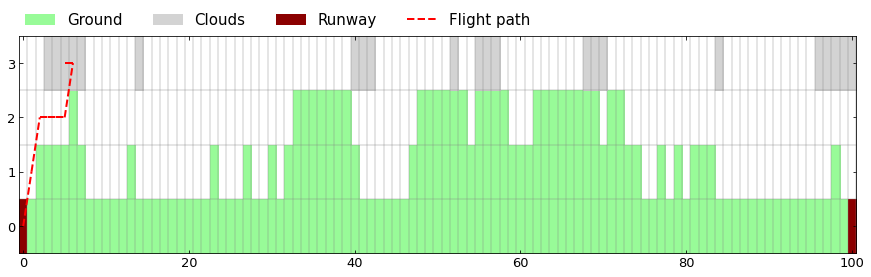

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_itr1.pdf


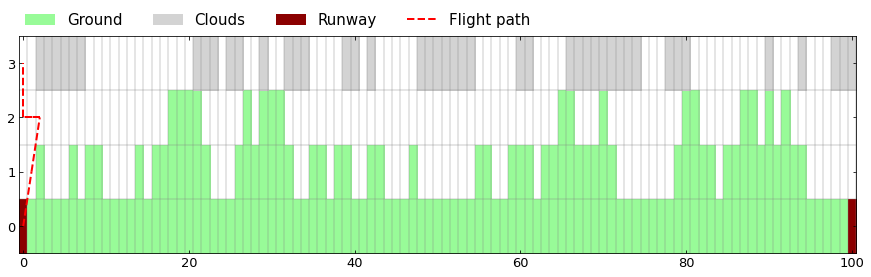

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_itr2.pdf


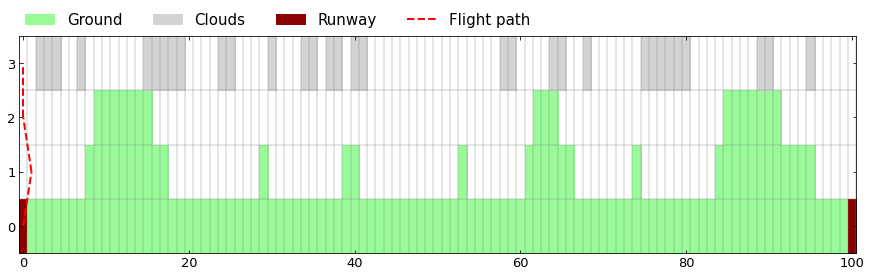

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_itr3.pdf


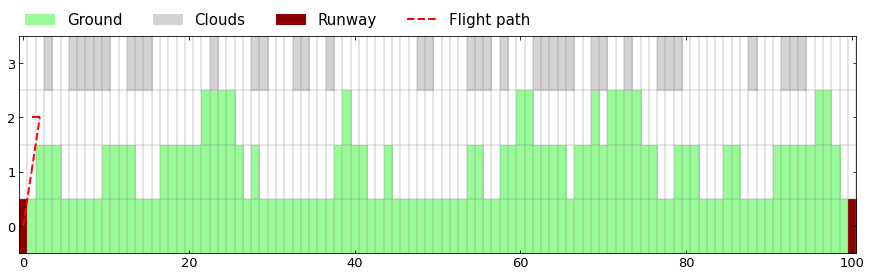

In [12]:
###
###  Plot the flightpaths evaluated for a number of different randomly generated maps
###
#
#  Configure the length and number of flights to show
#

length      = 101
num_flights = 4

#
#  Loop and plot flights requested
#
for flight_idx in range(num_flights) :
    game_board = generate_game_board(length=length)
    fig, ax = draw_flightpath(game_board, a6_policy, 
                              savefile=f"figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_itr{flight_idx}.pdf")
    plt.show(fig)
    plt.close(fig)
    

### Study example which encourages movement towards the right to break left<->right degeneracy

Since the expected return is $G_t = \mathbb{E}\left[R_t + \gamma v\left(s'\right)\right]$, if both left and right actions take us to the same next state $s'$ then $v\left(s'\right)$ is degenerate. However we now break this degeneracy by modifying the expected reward signal $R_t$ instead. So right actions will still be chosen in these examples.

However, if we choose the reward to be too small (e.g. here we use $-1$), it will still not work! This is because other penalties (e.g. flying into a cloud) may outweigh the reward. In this case, we see that the agent often turns left to avoid flying into a cloud. This is because it still cannot understand the long-term consequences of doing this. Thus this becomes a tricky balancing act just to solve our the fundamental problem of our badly defined state. A better approach should be to model the value function using the fully unbinned distance-to-goal information, then the agent could understand the long-term consequences of turning left.

In [13]:
###
###  Change configuration to reward actions which transform state to the right
###

reward_actions_right(True)

True

In [14]:
###
###  Perform policy iteration
###

num_itr   = 10000    # Number of times to iterate policy
num_subtr = 1        # Number of times to iterate action values before performing greedy policy update
length    = 21       # Length of maps to generate

a6_policy_with_right_reward = perform_policy_iteration(num_itr, num_subtr, length)


Policy iteration 100% complete [23.19s]

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_Rrewarded_itr0.pdf


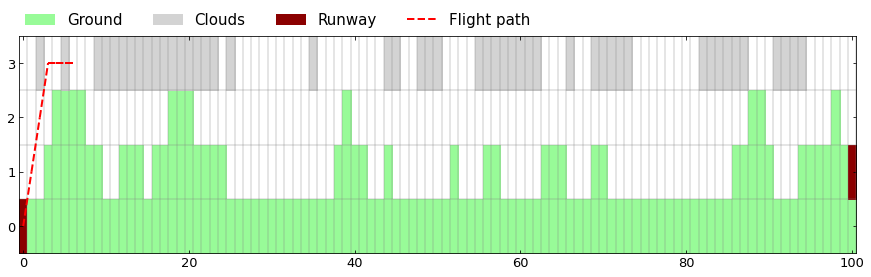

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_Rrewarded_itr1.pdf


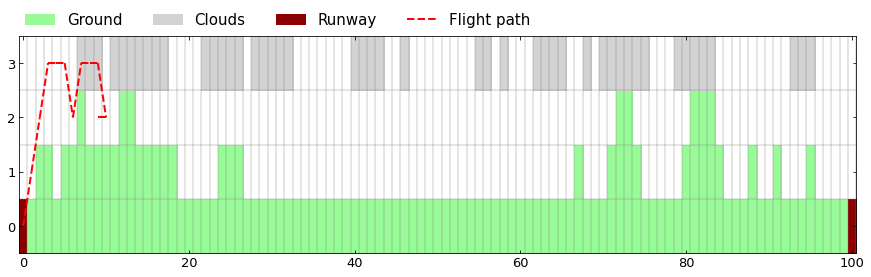

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_Rrewarded_itr2.pdf


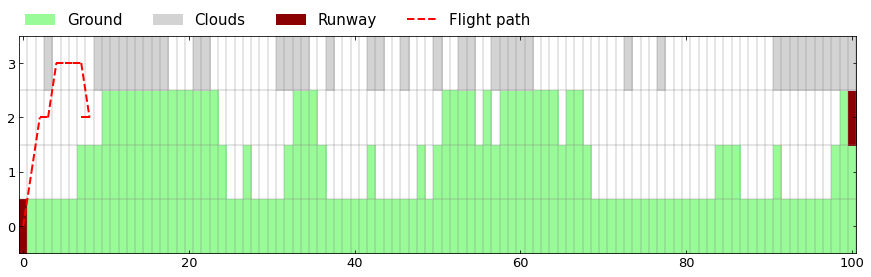

Figure saved to file figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_Rrewarded_itr3.pdf


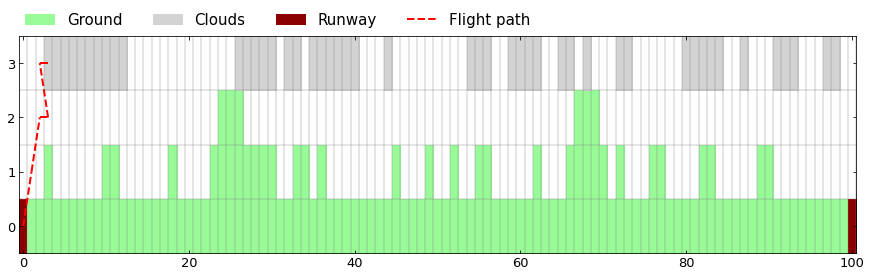

In [15]:
###
###  Plot the flightpaths evaluated for a number of different randomly generated maps
###
#
#  Configure the length and number of flights to show
#

length      = 101
num_flights = 4

#
#  Loop and plot flights requested
#
for flight_idx in range(num_flights) :
    game_board = generate_game_board(length=length)
    fig, ax = draw_flightpath(game_board, a6_policy_with_right_reward, 
                              savefile=f"figures/Simple_adaptive_flight_dynamic_programming/Flightpath_6actions_Rrewarded_itr{flight_idx}.pdf")
    plt.show(fig)
    plt.close(fig)
    